In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table

import os

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle

import xspec as x

from scipy.optimize import fsolve

from tqdm import tqdm

#### For eROSITA 30.0x30.0 field we take all clusters within the lightcone (flag=0) with $M_{500}> 10^{14} M_{\odot}$:

In [2]:
clusters = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/cluster.dat", sep='\s+', header=0)
clusters = clusters[clusters["M500"]>1e14]
clusters = clusters[clusters["flag"]==0]
clusters

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
171,110,0.970969,0.479718,0.014316,0.004703,2.432930e+14,0.157249,0.157891,1.366960e+14,688.128,4.470500e+12,1.209540e+13,2.44633,0.707698,0.000003,2.049620e+14,1068.920,0
187,163,0.388924,0.570999,0.016006,0.004675,2.390080e+14,0.157312,0.159659,1.126680e+14,645.187,2.896080e+12,1.061830e+13,2.43074,0.532571,0.000003,2.049290e+14,1068.880,0
350,77,0.380183,0.570491,0.033800,0.005197,3.282700e+14,0.157977,0.157810,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.515690,0.000005,2.887220e+14,1198.270,0
820,68,0.735543,0.863489,0.086085,0.005228,3.341870e+14,0.159935,0.160192,1.800240e+14,754.271,6.340420e+12,1.596800e+13,3.57076,0.972861,0.000004,2.724390e+14,1175.290,0
1245,111,0.804864,0.355207,0.133510,0.004668,2.379170e+14,0.161713,0.161111,1.321030e+14,680.349,4.667490e+12,9.869480e+12,2.78095,0.452088,0.000003,1.944720e+14,1050.360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,113,0.839159,0.495644,0.394607,0.011199,2.242680e+14,0.063945,0.063977,1.184480e+14,615.838,2.883010e+12,1.160680e+13,2.22808,0.537683,0.000002,1.889120e+14,976.536,0
18610,199,0.149218,0.307198,0.406194,0.011455,2.400200e+14,0.064342,0.064928,1.282700e+14,632.408,3.427130e+12,1.130680e+13,2.26553,0.455429,0.000002,1.935300e+14,984.440,0
19523,349,0.373303,0.943536,0.987909,0.010375,1.783400e+14,0.084342,0.084015,1.055570e+14,592.650,3.313370e+12,6.942770e+12,2.39539,0.231120,0.000002,1.464050e+14,897.005,0
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


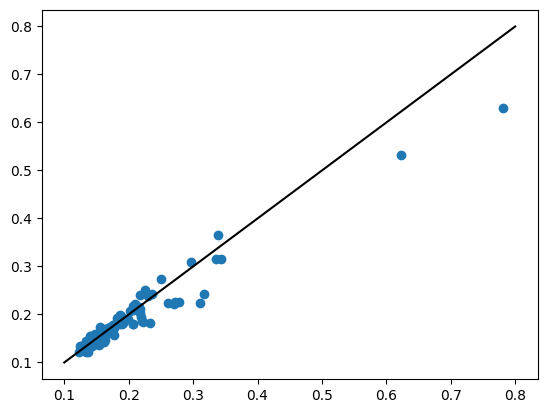

In [5]:
R_vir = clusters["Rrel"]*30
D_A = FlatLambdaCDM(H0=100*0.704, Om0=0.272).angular_diameter_distance(clusters["z_true"])*1000 # kpc
R_200 = clusters["R200"]/0.704/D_A.value*180/np.pi

plt.scatter(R_vir, R_200)
plt.plot([0.1,0.8], [0.1,0.8], color='k')

In [3]:
dd = clusters["R500"]/clusters["R200"]
dd

171      0.643760
187      0.603610
350      0.643721
820      0.641774
1245     0.647729
           ...   
18589    0.630635
18610    0.642404
19523    0.660699
19771    0.677179
19787    0.616953
Length: 84, dtype: float64

In [4]:
np.mean(dd)**3*5/2

0.6634716123842194

In [5]:
mm = clusters["M500"]/clusters["M200"]
mm

171      0.666933
187      0.549790
350      0.666849
820      0.660786
1245     0.679291
           ...   
18589    0.627001
18610    0.662791
19523    0.720993
19771    0.776383
19787    0.587075
Length: 84, dtype: float64

In [6]:
np.mean(mm)

0.6653610014476394

ihal: HaloID

x_pix,y_pix: position of the cluster in the Lightcone [0..1]. Multiply by 30
             degree to get position in sky.
             
z_pix:       relative position within the slice [0..1]

Note on x_pix,y_pix,z_pix: Objects are included if their size overlaps with the
                           Lightcone, therefore these central positions can be
                           slightly outside the Lightcone. The value of flag 
                           (last column) indicates if a object is fully within
                           the Lightcone (0) or if it is only partially within
                           the Lightcone (1).
                           
Rrel:        relative size of the virial radius (TopHat). Multiply by 30 degree
             to obtain the size of the virial radius on the sky.
             
Mvir         Nvir (TopHat) in Msol/h

z_true:      real redshift of the object (use this for distances)

z_obs:       redshift as spectroscopicly observed (use this as observed redshift)

M500:        M500 (critical) in Msol/h

R500:        R500 (critical) in kpc/h

Mstar500:    Stellar mass within R500 (critical) in Msol/h

Mgas500:     Gas mass within R500 (critical) in Msol/h

T500:        Mass weighted temperature within R500 (critical) in keV

Lx500:       Bolometric X-Ray luminosity within R500 (critical) in 1e44 erg/s

Ysz500:      ComptonY within R500 (critical)

M200:        M200 (critical) in Msol/h

R200         R200 (critical) in kpc/h

flag:        Indication if object is fully (=0) or only partial (=1) within the
             Lightcone.

In [7]:
len(clusters), min(clusters["z_true"]), max(clusters["z_true"])

(84, 0.034098784, 0.19434476)

#### Testing if masses and radii are connected through NFW profile:

${\displaystyle M=\int _{0}^{R_{\max }}4\pi r^{2}\rho (r)\,dr=4\pi \rho _{0}R_{s}^{3}\left[\ln \left({\frac {R_{s}+R_{\max }}{R_{s}}}\right)-{\frac {R_{\max }}{R_{s}+R_{\max }}}\right]}$

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html

In [232]:
def M_from_R(rad, RHO0, RS):
    
    return 4*np.pi* RHO0 * RS**3 * np.log((RS+rad)/RS) - R_500/(RS+rad)


def A_NFW(RMAX, RS):
    
    return np.log( (RS+RMAX)/RS) - RMAX/(RS+RMAX)


def equations(vars):
    
    rho_0, R_S = vars
    
    #print(R_S)
    
    eq1 = M_500 - 4*np.pi*rho_0 * R_S**3 * np.log((R_S+R_500)/R_S) - R_500/(R_S+R_500)
    
    eq2 = M_vir - 4*np.pi*rho_0 * R_S**3 * np.log((R_S+R_vir)/R_S) - R_vir/(R_S+R_vir)
    
    eq3 = M_200 - 4*np.pi*rho_0 * R_S**3 * np.log((R_S+R_200)/R_S) - R_200/(R_S+R_200)
    
    return [eq1, eq2]

In [233]:
redshifts = clusters["z_true"]

# angular diameter distances
adds = FlatLambdaCDM(H0=100*0.704, Om0=0.272).angular_diameter_distance(redshifts)*1000
adds = [a.value for a in adds.values]

masses_500 = clusters["M500"]*0.704
radii_500 = clusters["R500"]*0.704    #kpc
masses_vir = clusters["Mvir"]*0.704

radii_rel = clusters["Rrel"]
radii_rel = radii_rel*np.array(adds)  #kpc
radii_vir = {}

for i in radii_rel.keys():
    
    radii_vir[i] = radii_rel[i]*30*np.pi/180

masses_200 = clusters["M200"]*0.704
radii_200 = clusters["R200"]*0.704    #kpc

In [234]:
cl_number = 820

M_500 = masses_500[cl_number]
R_500 = radii_500[cl_number]
M_vir = masses_vir[cl_number]
R_vir = radii_vir[cl_number]
M_200 = masses_200[cl_number]
R_200 = radii_200[cl_number]

In [235]:
guess = [10**6, 200]

x, y = fsolve(equations, guess)

print(x,y)

print(R_vir/y)

216402.5790183162 375.29918699278676
4.137952383354426


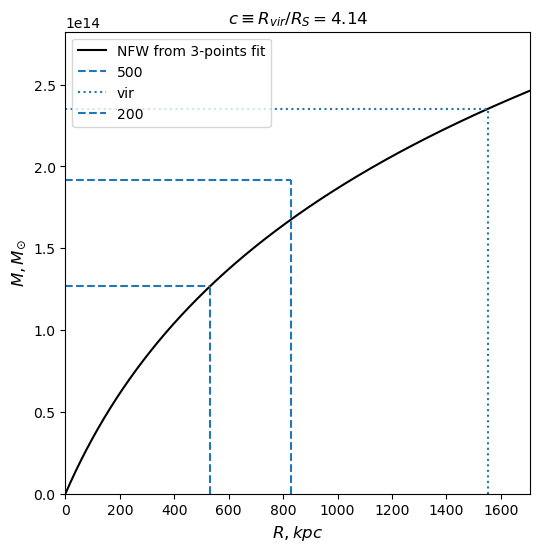

In [236]:
plt.figure(figsize=(6,6))

rrr = np.linspace(0, 3000, 3000)
mmm = M_from_R(rrr, x, y)

plt.plot(rrr, mmm, color='black', label='NFW from 3-points fit')

plt.xlim(0, R_vir*1.1)
plt.ylim(0, M_vir*1.2)

plt.axvline(R_500, ls='--', ymax=M_500/plt.gca().get_ylim()[1], label='500')
plt.axvline(R_vir, ls=':',  ymax=M_vir/plt.gca().get_ylim()[1], label='vir')
plt.axvline(R_200, ls='--', ymax=M_200/plt.gca().get_ylim()[1], label='200')

plt.axhline(M_500, ls='--', xmax=R_500/plt.gca().get_xlim()[1])
plt.axhline(M_vir, ls=':',  xmax=R_vir/plt.gca().get_xlim()[1])
plt.axhline(M_200, ls='--', xmax=R_200/plt.gca().get_xlim()[1])

plt.title(f"$c \equiv R_{{vir}}/R_{{S}} = {R_vir/y:.2f}$")
plt.xlabel("$R, kpc$", fontsize=12)
plt.ylabel("$M, M_{\odot}$", fontsize=12)
#plt.xticks(list(plt.xticks()[0]) + [y])
plt.legend()

plt.show()

#### Draw all 84 $M(R)$ graphics:

/tmp/ipykernel_5825/3587567193.py:21: RuntimeWarning: invalid value encountered in log
  eq1 = M_500 - 4*np.pi*rho_0 * R_S**3 * np.log((R_S+R_500)/R_S) - R_500/(R_S+R_500)
/tmp/ipykernel_5825/3587567193.py:23: RuntimeWarning: invalid value encountered in log
  eq2 = M_vir - 4*np.pi*rho_0 * R_S**3 * np.log((R_S+R_vir)/R_S) - R_vir/(R_S+R_vir)
/tmp/ipykernel_5825/3587567193.py:21: RuntimeWarning: invalid value encountered in log
  eq1 = M_500 - 4*np.pi*rho_0 * R_S**3 * np.log((R_S+R_500)/R_S) - R_500/(R_S+R_500)
/tmp/ipykernel_5825/3587567193.py:23: RuntimeWarning: invalid value encountered in log
  eq2 = M_vir - 4*np.pi*rho_0 * R_S**3 * np.log((R_S+R_vir)/R_S) - R_vir/(R_S+R_vir)
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/tmp/ipykernel_5825/3587567193.py:21: RuntimeWarning: invalid value encountered in log

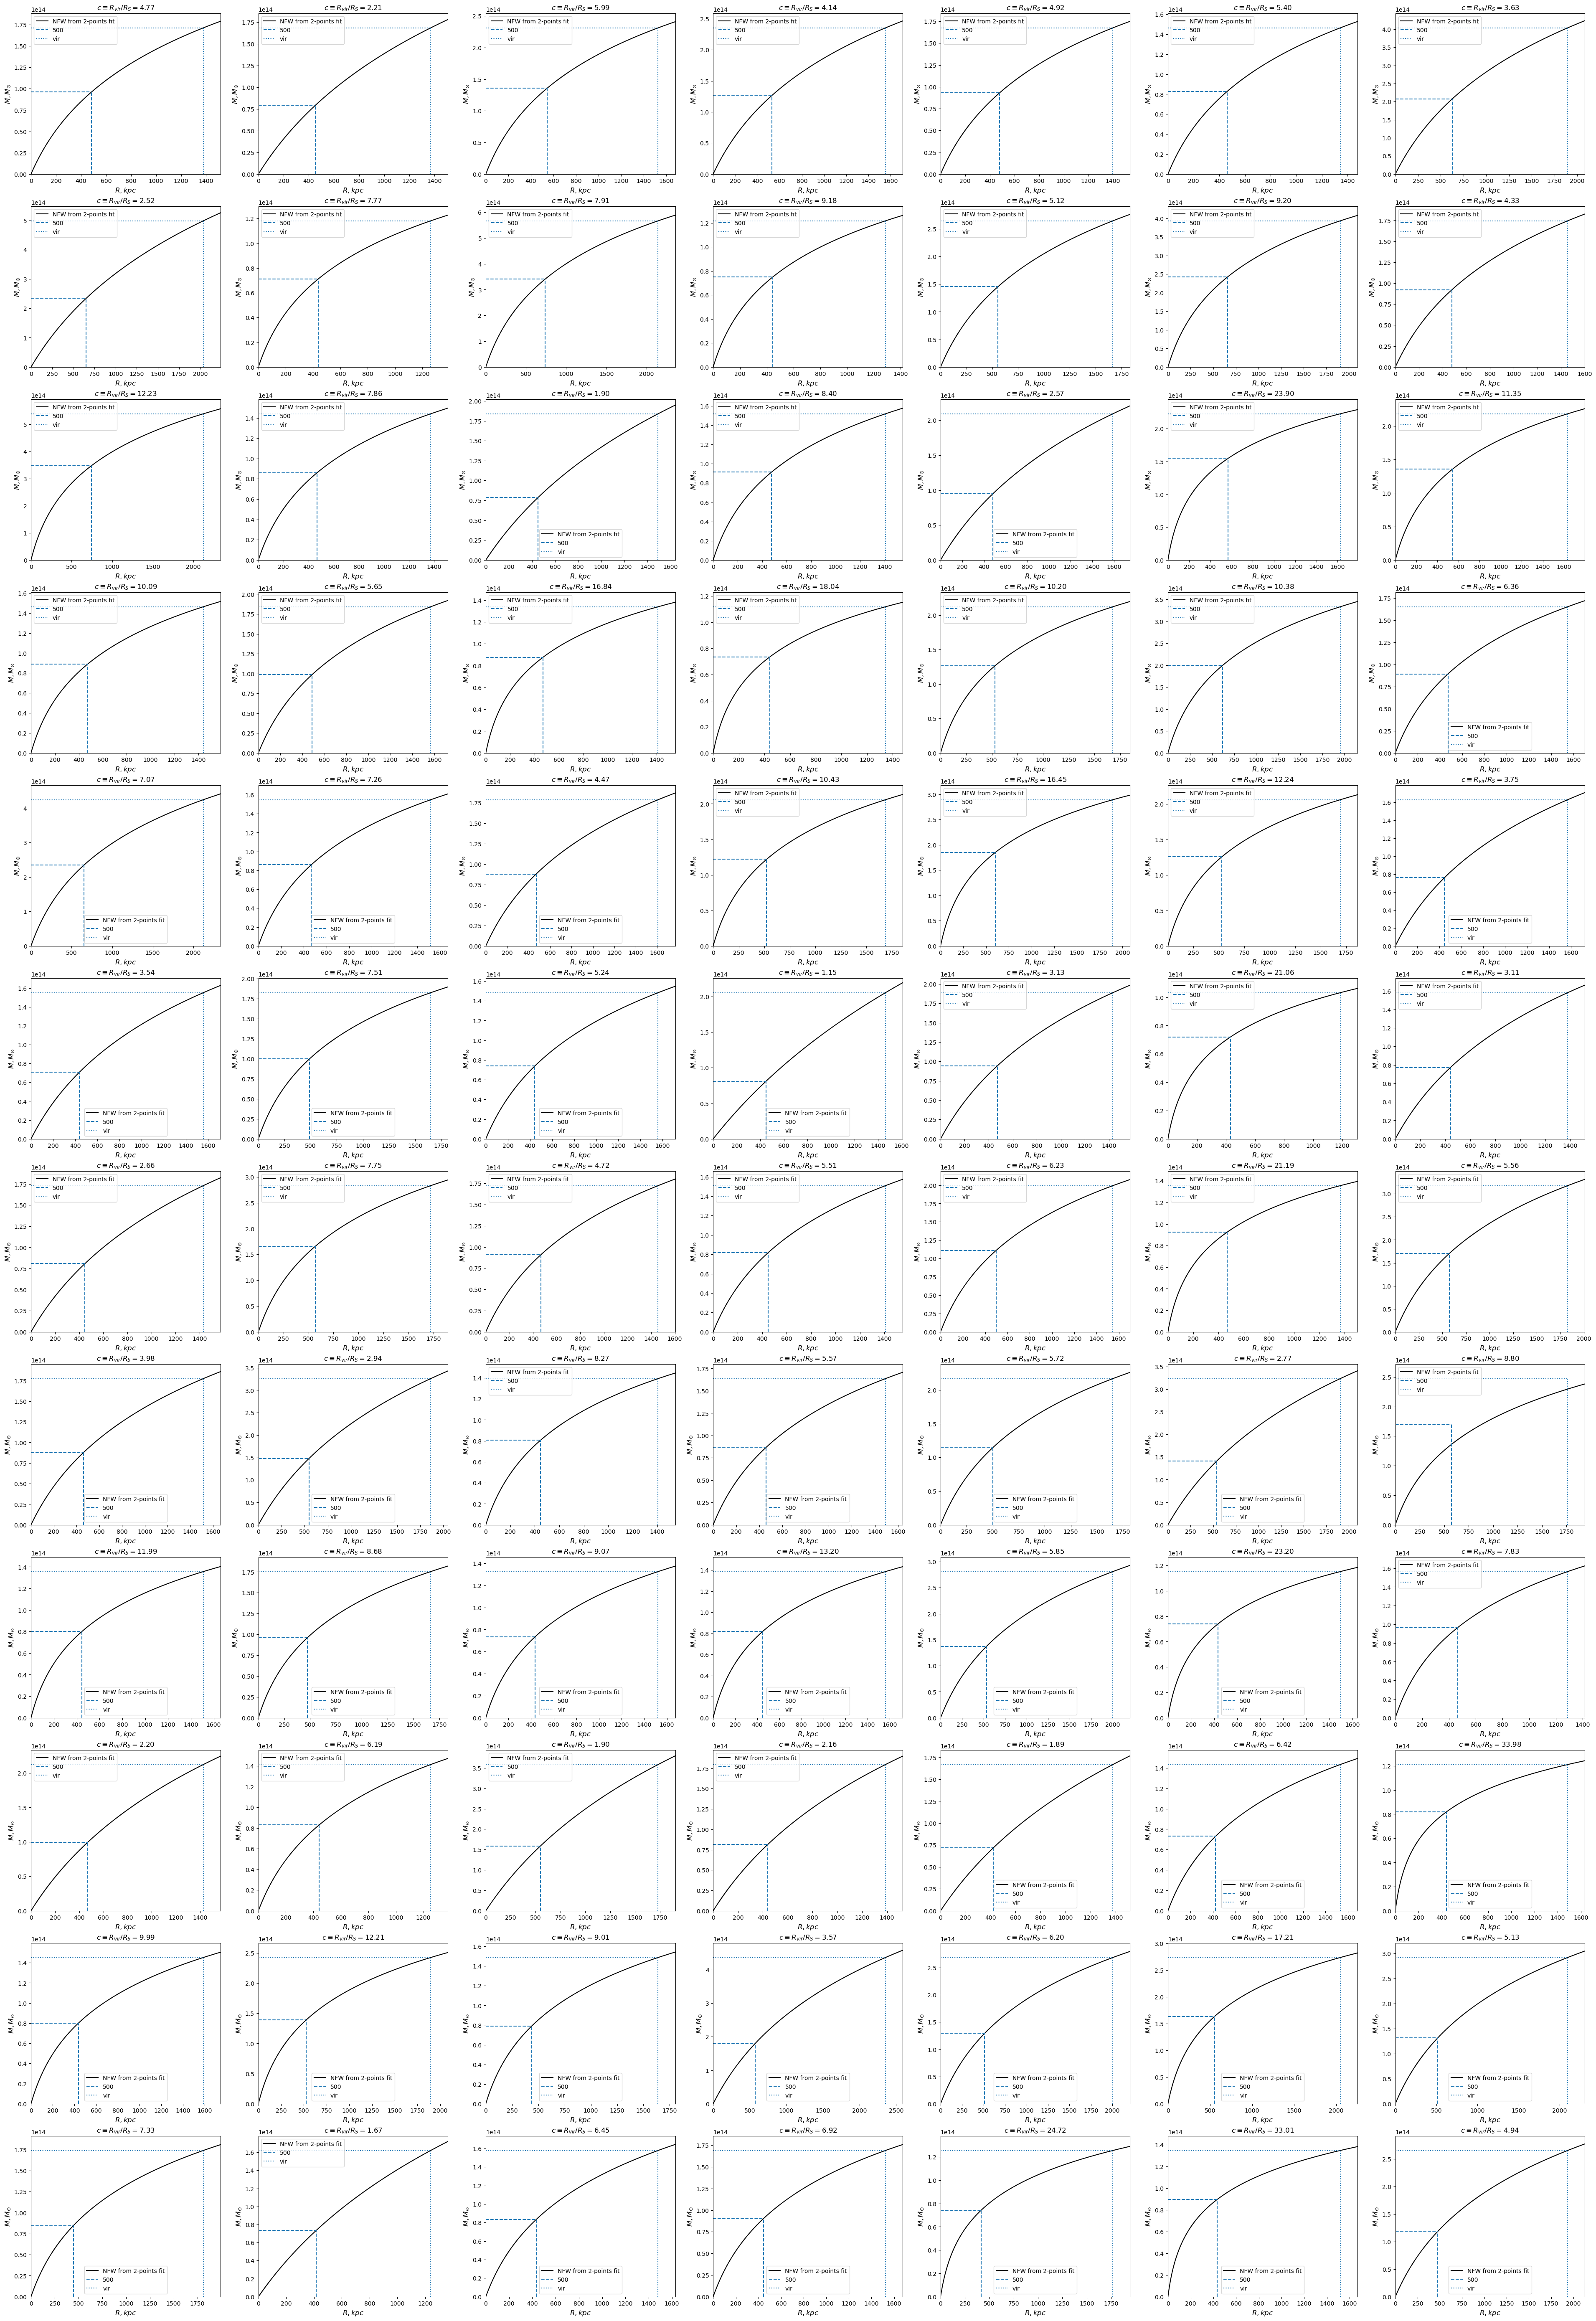

In [200]:
NNN = 84

size=6

plt.figure(figsize=((size)*7+6, 5*12+11))
plt.tight_layout()

for cl_number in clusters.index[:NNN]:

    plt.subplot(12, 7, np.where(np.array(clusters.index[:NNN]) == cl_number)[0][0]+1)

    M_500 = masses_500[cl_number]
    R_500 = radii_500[cl_number]
    M_vir = masses_vir[cl_number]
    R_vir = radii_vir[cl_number]

    def equations(vars):

        rho_0, R_S = vars

        eq1 = M_500 - 4*np.pi*rho_0 * R_S**3 * np.log((R_S+R_500)/R_S) - R_500/(R_S+R_500)

        eq2 = M_vir - 4*np.pi*rho_0 * R_S**3 * np.log((R_S+R_vir)/R_S) - R_vir/(R_S+R_vir)

        return [eq1, eq2]

    initial_guess = [10**6, 200]

    x, y = fsolve(equations, initial_guess, maxfev=500)

    rrr = np.linspace(0, 3000, 3000)
    mmm = M_from_R(rrr, x, y)

    plt.plot(rrr, mmm, color='black', label='NFW from 2-points fit')

    plt.xlim(0., R_vir*1.1)
    plt.ylim(0, M_vir*1.1)

    plt.axvline(R_500, ls='--', ymax=M_500/plt.gca().get_ylim()[1], label='500')
    plt.axvline(R_vir, ls=':',  ymax=M_vir/plt.gca().get_ylim()[1], label='vir')

    plt.axhline(M_500, ls='--', xmax=R_500/plt.gca().get_xlim()[1])
    plt.axhline(M_vir, ls=':',  xmax=R_vir/plt.gca().get_xlim()[1])

    plt.title(f"$c \equiv R_{{vir}}/R_{{S}} = {R_vir/y:.2f}$")
    plt.xlabel("$R, kpc$", fontsize=12)
    plt.ylabel("$M, M_{\odot}$", fontsize=12)
    plt.legend()

plt.show()
        

#### ZuHone's figure 1:

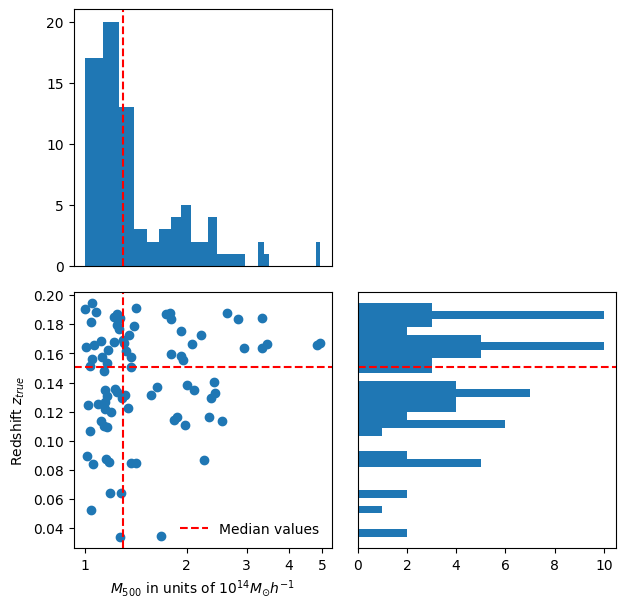

In [7]:
plt.figure(figsize = (7,7))

plt.subplot(221)
plt.hist(clusters["M500"]/10**14, bins=30, histtype='stepfilled')
#plt.xlabel("$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")
plt.xticks([])
plt.axvline(np.median(clusters["M500"]/10**14), linestyle='--', color='red')
plt.xscale("log")
#plt.xticks([1,2,3,4,5], [1,2,3,4,5])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.yticks([0,5,10,15,20], [0,5,10,15,20])

plt.subplot(224)
plt.hist(clusters["z_true"], bins=30, histtype='stepfilled', orientation="horizontal")
#plt.xlabel("Redshift $z_{true}$")
plt.yticks([])
plt.axhline(np.median(clusters["z_true"]), linestyle='--', color='red')

#plt.show()

#plt.figure(figsize = (5,5))

plt.subplot(223)

plt.scatter(clusters["M500"]/10**14, clusters["z_true"])
#plt.scatter(clusters["z_obs"], clusters["M500"]/10**14)
plt.ylabel("Redshift $z_{true}$")
plt.xlabel("$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")
plt.xscale("log")
plt.xticks([1,2,3,4,5], [1,2,3,4,5])
#plt.yscale("log")
plt.axvline(np.median(clusters["M500"]/10**14), linestyle='--', color='red')
plt.axhline(np.median(clusters["z_true"]), linestyle='--', color='red', label="Median values")
plt.legend(frameon=False)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.savefig('figures/histogram_84.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [9]:
np.median(clusters["M500"]/10**14)

1.30194

In [10]:
np.median(clusters["z_true"])

0.150852875

The redshift used in computing distances $z_{true}$ is obtained by computing the offset of the cluster center from the center of the slice, and the redshift used in fitting spectra $z_{obs}$ also takes into account the peculiar velocity of the cluster within the slice. 

#### Plotting all these clusters in 2D:

In [8]:
x_c = 30*clusters["x_pix"].values    # deg
y_c = 30*clusters["y_pix"].values    # deg
#z_c = clusters["z_pix"]              # relative position within the slice [0...1]
z_c = clusters["z_true"]

r_500 = clusters["R500"].values        # kpc/h
redshifts = clusters["z_true"].values

h = 0.704
Omega_M = 0.272
D_A = FlatLambdaCDM(H0=100*h, Om0=Omega_M).angular_diameter_distance(redshifts) # Mpc

r_500_rescaled = [num/denom*180/np.pi for num, denom in zip(r_500*h, 1000*D_A.value)]  # degrees

R_vir = 30*clusters["Rrel"].values

#### Example from `run_phox_cluster_erosita_lightcone.cmd` as motivator to take Rrel*30 as $R_{500}$:

In [10]:
clusters.iloc[28]["x_pix"]*30-5, clusters.iloc[28]["y_pix"]*30-5, clusters.iloc[28]["Rrel"]*30

(17.6464642, 18.0108214, 0.190842306)

#### Please note that $R_{rel}$ (virial radius) is taken as $R_{500}$, which may be bad decision!

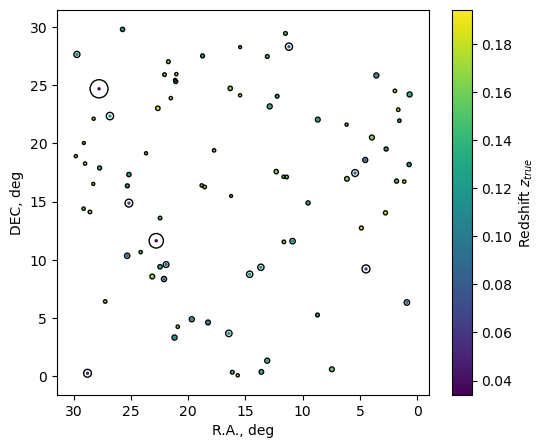

In [11]:
plt.figure(figsize=(6,5))#, layout='constrained')

plt.scatter(x_c, y_c, c=redshifts, cmap='viridis', s=2)

for xc, yc, r in zip(x_c, y_c, R_vir):
    plt.gca().add_patch( plt.Circle( (xc, yc), r, fill = False) )
    
plt.gca().invert_xaxis()
    
plt.colorbar(label="Redshift $z_{true}$")

plt.xlabel("R.A., deg")
plt.ylabel("DEC, deg")

plt.show()

#### Adding slices from Phox and drawing in 3D:

In [5]:
wd = "../data/eROSITA_30.0x30.0/Phox/"
mylist = sorted(os.listdir(wd))

phlists = [item for item in mylist if item[:6] == "phlist"]

print(phlists)

phlists_redshifts = [fits.open(wd+item)[0].header["REDSHIFT"] for item in phlists]#[::-1]

print(phlists_redshifts)

['phlist_124.fits', 'phlist_128.fits', 'phlist_132.fits', 'phlist_136.fits', 'phlist_140.fits']
[0.174192889973847, 0.13708140389145, 0.101142861718869, 0.0663401914452304, 0.032637492755919]


#### ...considering `geometry.dat`...

In [6]:
geometry = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/geometry.dat", sep='\s+', header=2)
geometry

,snapNr,ztab,zslice,z_start,z_end,x0,y0,z0,depth,width
0,144,0.001001,0.008625,0.000000,0.017281,230.604600,52.929941,38.137176,73.327162,21.167728
1,140,0.033671,0.033822,0.017281,0.050478,305.341400,149.855590,172.109480,139.387980,82.573299
2,136,0.067408,0.067555,0.050478,0.084760,97.871486,134.586170,117.805860,141.855220,163.761220
3,132,0.102245,0.102388,0.084760,0.120158,185.353850,229.067940,294.134880,144.222380,246.344710
4,128,0.138220,0.138357,0.120158,0.156713,146.337120,179.784950,264.241690,146.478010,330.262680
5,124,0.175368,0.175501,0.156713,0.194460,170.716390,187.570430,175.891600,148.610980,415.447530


#### (there are no clusters of interest in snap number 144)

snapNr:   Snap Number

ztab:     redshift of the simulation output used for the slice

zslice:   mean redshift of the slice (e.g. redshift corresponding to the mean popper distance of the slice)

z_start:  minimum redshift of the slice

z_end:    maximum redshift of the slice

x0,y0,z0: Center position of the box used

depth:    proper distance in z direction of the slice in Mpc

width:    proper distance of the field of view in Mpc

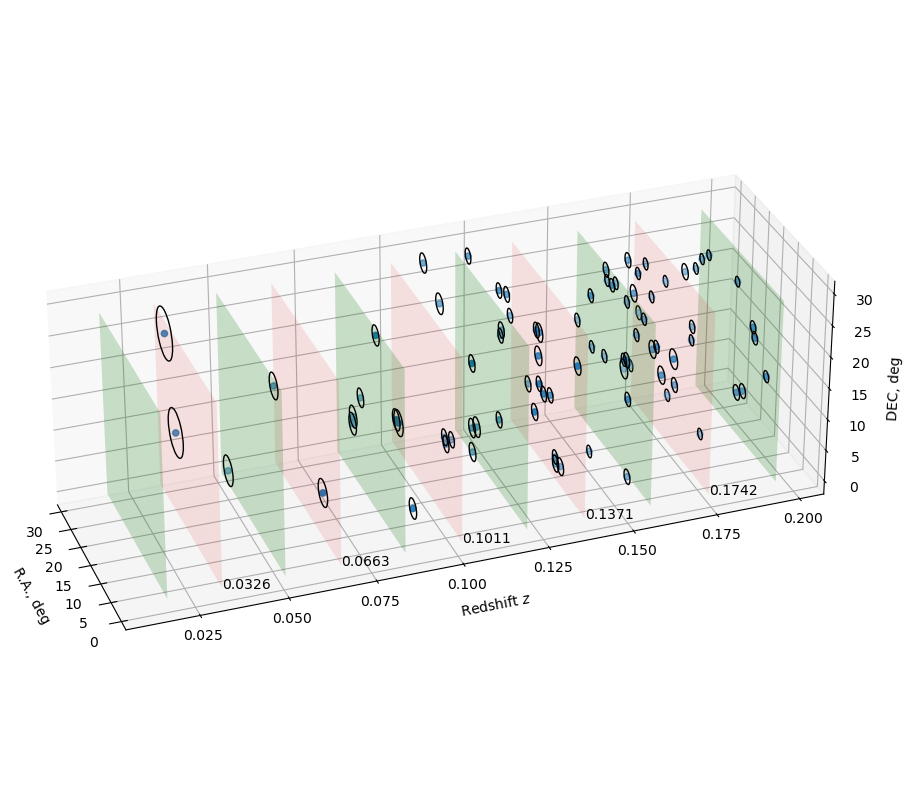

In [9]:
fig = plt.figure(figsize=(10,8), layout="constrained")

ax = fig.add_subplot(projection='3d')

ax.scatter(x_c, redshifts, zs=y_c, zdir='z', cmap='viridis')

for xc, yc, r, rdsh in zip(x_c, y_c, r_500_rescaled, redshifts):
    p = Circle( (xc, yc), r*20, fill = False)
    ax.add_patch(p)
    art3d.pathpatch_2d_to_3d(p, z=rdsh, zdir="y")

ax.set_xlabel("R.A., deg")
ax.set_ylabel('\n \n Redshift $z$')
ax.set_zlabel("DEC, deg")

ax.invert_xaxis()

xx, yy = np.meshgrid(range(30), range(30))
for rdsh in phlists_redshifts:
    ax.plot_surface(xx, rdsh, yy, alpha=0.1, color='red')
    ax.text(0, rdsh, 0, f"{rdsh:.4f}")
    
xx, yy = np.meshgrid(range(30), range(30))
for rdsh in geometry["z_end"]:
    ax.plot_surface(xx, rdsh, yy, alpha=0.2, color='green')

ax.view_init(elev=30., azim=-20)

ax.set_box_aspect(aspect = (1,3,1), zoom = 1)

ax.set_title("Note: $R_{500}$\'s are multiplied by 20 for visibility")

plt.savefig('figures/3d_view.pdf', format='pdf', bbox_inches='tight')
plt.show()

Green is `z_end`, red -- `z_slice`, blue dots are clusters. Black cirles are $R_{500}$'s multiplied by 5 for visibility and comparison.

#### Binning clusters between slices (keys = halo index (not ihal!), values = redshifts and snap ID's of slices):

In [15]:
#binned_clusters = {}
    
#for ind in clusters.index:
    
#    cl = clusters.loc[ind]
    
#    zxcvbn = cl["z_true"]
    
#    #print(ind, zxcvbn)
    
#    for i in range(0, len(phlists_redshifts)):
        
#        #print(zxcvbn, phlists_redshifts[i])
    
#        if zxcvbn > phlists_redshifts[i]:
            
#            binned_clusters[ind] = phlists_redshifts[i], phlists[i][7:10]
            
#            #print(zxcvbn, phlists_redshifts[i], binned_clusters[ind])
            
#            break
                
#binned_clusters

In [16]:
binned_clusters = {}
   
for borders in list(zip(geometry["z_start"], geometry["z_end"], geometry["zslice"], geometry["snapNr"])):
        
    #print(borders)
    
    for ind in clusters.index:

        cl = clusters.loc[ind]

        zxcvbn = cl["z_true"]

        #print(ind, zxcvbn)

        if zxcvbn > borders[0] and zxcvbn < borders[1]:

            binned_clusters[ind] = borders[2], str(borders[3])
                
sorted(binned_clusters.items())

[(171, (0.17550106, '124')),
 (187, (0.17550106, '124')),
 (350, (0.17550106, '124')),
 (820, (0.17550106, '124')),
 (1245, (0.17550106, '124')),
 (1380, (0.17550106, '124')),
 (1707, (0.17550106, '124')),
 (1819, (0.17550106, '124')),
 (1838, (0.17550106, '124')),
 (2270, (0.17550106, '124')),
 (2386, (0.17550106, '124')),
 (2421, (0.17550106, '124')),
 (2471, (0.17550106, '124')),
 (2593, (0.17550106, '124')),
 (2603, (0.17550106, '124')),
 (2815, (0.17550106, '124')),
 (2904, (0.17550106, '124')),
 (3155, (0.17550106, '124')),
 (3886, (0.17550106, '124')),
 (3985, (0.17550106, '124')),
 (4613, (0.17550106, '124')),
 (4967, (0.17550106, '124')),
 (5326, (0.17550106, '124')),
 (5443, (0.17550106, '124')),
 (6001, (0.17550106, '124')),
 (6496, (0.17550106, '124')),
 (6529, (0.17550106, '124')),
 (6582, (0.17550106, '124')),
 (6695, (0.17550106, '124')),
 (6740, (0.17550106, '124')),
 (7191, (0.17550106, '124')),
 (7308, (0.17550106, '124')),
 (7364, (0.17550106, '124')),
 (7409, (0.175

### TODO: 

Maybe its better to invert dictionary.

#### Binning clusters and checking if they are binned correctly

[0.032637492755919, 0.0663401914452304, 0.101142861718869, 0.13708140389145, 0.174192889973847, 0.2]


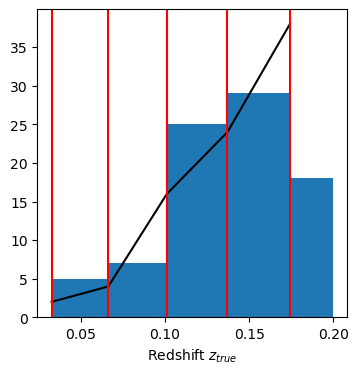

In [17]:
BINS = phlists_redshifts[::-1] + [0.2]

print(BINS)

plt.figure(figsize=(4,4))      
        
plt.hist(clusters["z_true"], bins=BINS, histtype='stepfilled')
plt.xlabel("Redshift $z_{true}$")

check = np.unique([a[0] for a in binned_clusters.values()], return_counts=True)[1] # if binned correctly
    
plt.plot(phlists_redshifts, check[::-1], color = 'black')

for rdsh in phlists_redshifts:
    plt.axvline(rdsh, color='red')

plt.show()

#### Facts

Programs distributed with HEASOFT are called “ftools”. If you want to know more about the parameters of an FTOOL, use the command fhelp ftoolname where “ftoolname” is the name of the FTOOL. To get a list of all available FTOOLS, use fhelp ftools.

`!fv ../data/eROSITA_30.0x30.0/Phox/phlist_140.fits`

`!fstruct ../data/eROSITA_30.0x30.0/Phox/phlist_140.fits`

#### Searching for photons from these clusters in photon lists. At first for one cluster. 

Steps: (1) take each snap, (2) choose only clusters related to this snap, (3) for each cluster choose only photons inside $R_{500}$.

In [14]:
snap_id = '140'

related_clusters = [i for i,j in binned_clusters.items() if j[1] == snap_id]
related_clusters

[19771, 19787]

In [15]:
current_cluster_num = related_clusters[1]

current_cluster_num

19787

In [16]:
current_cluster = clusters.loc[current_cluster_num]

current_cluster

ihal        8.300000e+01
x_pix       9.260318e-01
y_pix       8.229134e-01
z_pix       5.269593e-01
Rrel        2.605014e-02
Mvir        3.766600e+14
z_true      3.471737e-02
z_obs       3.399225e-02
M500        1.682650e+14
R500        6.769520e+02
Mstar500    5.699780e+12
Mgas500     1.686950e+13
T500        2.845680e+00
Lx500       9.512280e-01
Ysz500      3.578968e-06
M200        2.866160e+14
R200        1.097250e+03
flag        0.000000e+00
Name: 19787, dtype: float64

In [17]:
RA_c = current_cluster["x_pix"]*30-5
DEC_c = current_cluster["y_pix"]*30-5
R_vir = current_cluster["Rrel"]*30

R_500 = current_cluster["R500"]*0.704  # kpc
ztrue = current_cluster["z_true"]

D_A = FlatLambdaCDM(H0=100*0.704, Om0=0.272).angular_diameter_distance(ztrue)*1000 # kpc

R_500_rescaled = R_500/D_A.value*180/np.pi #degrees

RA_c, DEC_c, R_vir, R_500_rescaled

(22.780954599999998, 19.6874032, 0.7815042299999999, 0.19248360419179314)

In [18]:
snap_id_str = binned_clusters[current_cluster_num][1]

In [19]:
hdul = fits.open("../data/eROSITA_30.0x30.0/Phox/phlist_"+snap_id+".fits")

SLICE = pd.DataFrame(hdul[2].data[:])

display(SLICE)

hdul.close()

,ENERGY,RA,DEC
0,0.165827,11.067711,10.758957
1,0.208517,1.776705,9.079003
2,0.154514,11.083459,10.756147
3,0.114760,8.337882,3.265597
4,0.114936,8.325741,3.270800
...,...,...,...
7268680,0.683254,-0.438296,24.351841
7268681,0.700846,-0.458125,24.322994
7268682,0.715961,-0.452658,24.334837
7268683,0.769633,-0.451354,24.328300


In [20]:
def extract_photons(ra_cl, dec_cl, R_cl, snapID):
    
    t = Table.read("../data/eROSITA_30.0x30.0/Phox/phlist_"+snapID+".fits", hdu=2)
    
    SLICE = t.to_pandas()
    
    SLICE["check"]=np.where((SLICE["RA"]-ra_cl)**2+(SLICE["DEC"]-dec_cl)**2 <= R_cl**2, True, False)
    
    #display(SLICE)

    #if (ra_ph-x_cl)**2 + (dec_ph-y_cl)**2 <= r_cl**2:
     
    df = SLICE[SLICE['check'] == True]
    
    display(df)
    
    #df = df.drop("RA", axis=1)
    #df = df.drop("DEC", axis=1)
    
    return df.drop("check", axis=1)

    
dddfff = extract_photons(RA_c, DEC_c, R_vir, snap_id)

display(dddfff)

,ENERGY,RA,DEC,check
184796,0.232713,22.708536,19.498272,True
185726,0.252945,22.696968,20.356155,True
189203,0.196683,22.718506,19.820965,True
189204,0.103351,22.746279,19.735714,True
189205,0.115005,22.753073,19.729940,True
...,...,...,...,...
6339950,0.832822,22.417141,20.051483,True
6339951,0.902510,22.383286,20.031170,True
6339952,0.979782,22.383923,20.028664,True
6339953,0.980721,22.408531,20.045015,True


,ENERGY,RA,DEC
184796,0.232713,22.708536,19.498272
185726,0.252945,22.696968,20.356155
189203,0.196683,22.718506,19.820965
189204,0.103351,22.746279,19.735714
189205,0.115005,22.753073,19.729940
...,...,...,...
6339950,0.832822,22.417141,20.051483
6339951,0.902510,22.383286,20.031170
6339952,0.979782,22.383923,20.028664
6339953,0.980721,22.408531,20.045015


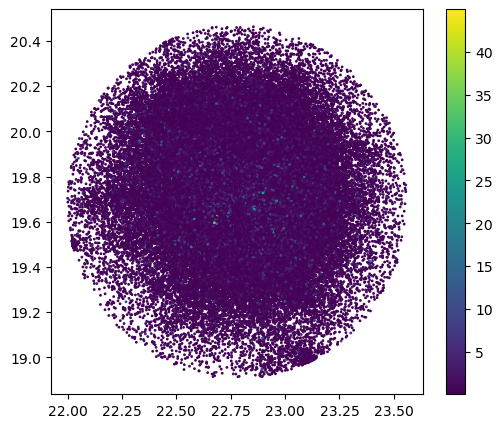

In [21]:
plt.figure(figsize=(6,5))

plt.scatter(dddfff["RA"], dddfff["DEC"], c=dddfff["ENERGY"], cmap='viridis', s=1)
plt.colorbar()
plt.show()

#### Checking eROSITA's RMF and ARF:

In [22]:
rrrr = fits.open('../erosita/erosita_pirmf_v20210719.rmf')
rrrr.info()
ff = rrrr[1].data
len(ff["E_MIN"])
#np.append(ff["E_MIN"], [12.0])

Filename: ../erosita/erosita_pirmf_v20210719.rmf
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  EBOUNDS       1 BinTableHDU     31   1024R x 3C   [I, E, E]   
  2  MATRIX        1 BinTableHDU     42   1024R x 6C   [E, E, I, 1PI(14), 1PI(14), 1PE(924)]   


1024

In [23]:
gggg = fits.open('../erosita/tm1_arf_open_000101v02.fits')
gggg.info()
hh = gggg[1].data
len(hh["ENERG_LO"])

Filename: ../erosita/tm1_arf_open_000101v02.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SPECRESP      1 BinTableHDU     41   1024R x 4C   [E, E, E, E]   


1024

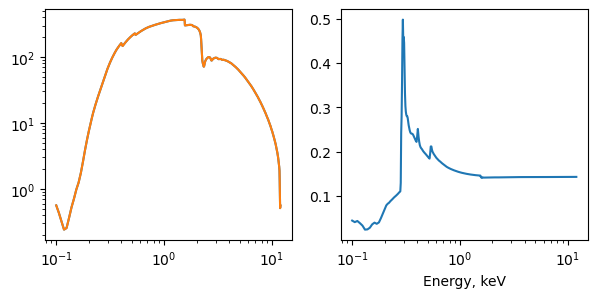

In [24]:
arf_ene1 = [a[0] for a in hh]
arf_ene2 = [a[0] for a in hh]
arf = [a[2] for a in hh]
contrib = [a[3] for a in hh]
#arf

plt.figure(figsize=(7,3))

plt.subplot(121)
plt.plot(arf_ene1, arf)
plt.plot(arf_ene2, arf)
#plt.plot([jjj[1] for jjj in hh], np.multiply([jjj[2] for jjj in hh], arf))
plt.xscale("log")
plt.yscale("log")

plt.subplot(122)
plt.plot(arf_ene1, contrib)
plt.xscale("log")
plt.xlabel("Energy, keV")

plt.show()

See [Appendix C: Adding Models to XSPEC](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node320.html).

### Writing a new model function

A model function is a subroutine that calculates the model spectrum given an input array of energy bins and an array of parameter values. The input array of energy bins gives the boundaries of the energy bins and hence has one more entry than the output flux arrays. The energy bins are assumed to be contiguous and will be determined by the response matrix in use. The subroutine should thus make no assumptions about the energy range and bin sizes. The output flux array for an additive model should be in terms of photons/cm$^2$/s (not photons/cm$^2$/s/keV) i.e. it is the model spectrum integrated over the energy bin. The output array for a multiplicative model is the multiplicative factor for that bin. Convolution models are operators on the output from additive or multiplicative models. Model subroutines can be written in Fortran, either in single or double precision, in C++ using either C++-style arguments or C-style arguments, and in C.

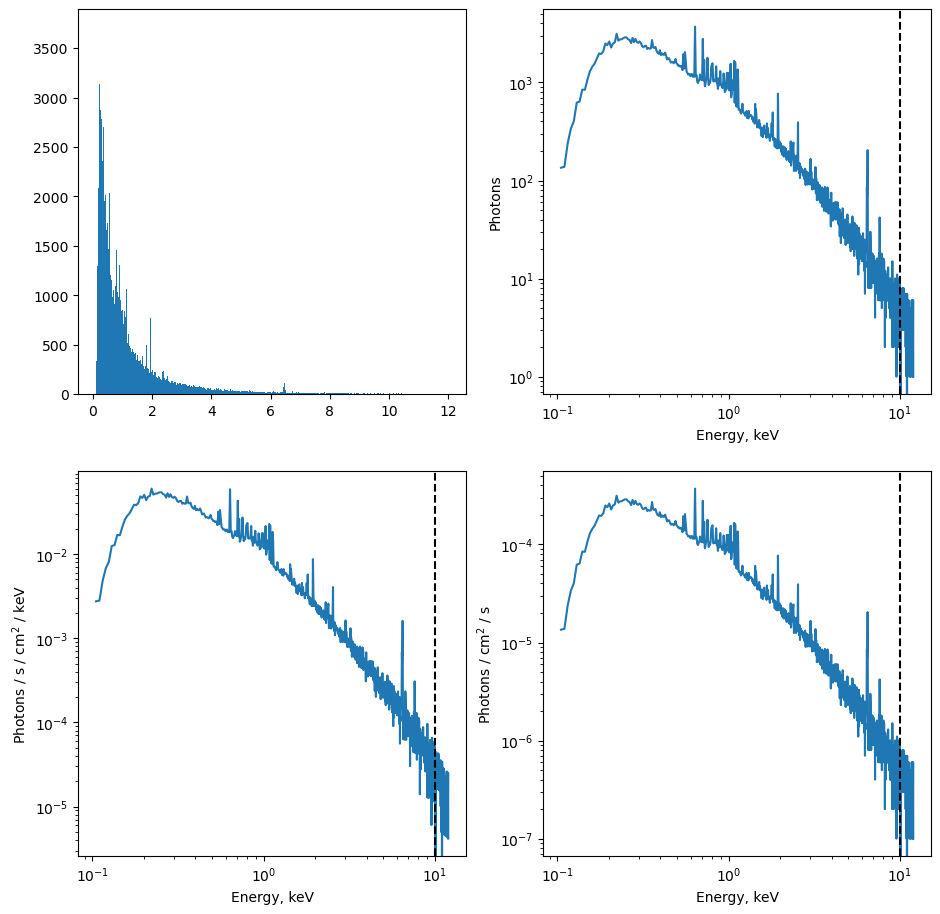

In [394]:
N_channels = 1024

# there is no big difference which binning to choose

#dummyrsp = np.linspace(0.1, 50.0, N_channels+1)
#dummyrsp = np.logspace(np.log10(0.1), np.log10(12.0), N_channels+1)
dummyrsp = np.append(ff["E_MIN"], [12.0])

plt.figure(figsize=(11, 11))

plt.subplot(221)
photons, energies, _ =  plt.hist(dddfff["ENERGY"], bins = dummyrsp)

plt.subplot(222)
plt.plot(energies[1:], photons)
plt.xscale('log')
plt.yscale('log')
plt.axvline(10.0, linestyle = '--', color='black')
plt.xlabel("Energy, keV")
plt.ylabel("Photons")

model_obs = [a/b/10000/1000 for a, b in zip(photons, np.diff(dummyrsp))]

plt.subplot(223)
plt.plot(energies[1:], model_obs)
plt.xscale('log')
plt.yscale('log')
plt.axvline(10.0, linestyle = '--', color='black')
plt.xlabel("Energy, keV")
plt.ylabel("Photons / s / cm$^2$ / keV")

model_obs1 = [a/10000/1000 for a in photons]

plt.subplot(224)
plt.plot(energies[1:], model_obs1)
plt.xscale('log')
plt.yscale('log')
plt.axvline(10.0, linestyle = '--', color='black')
plt.xlabel("Energy, keV")
plt.ylabel("Photons / cm$^2$ / s")

plt.show()

In [395]:
#datfile = pd.DataFrame({"ENERG_LO":energies[:-1], "ENERG_HI":energies[1:], "PHOTON_COUNTS":photons})
#datfile = pd.DataFrame({"PHOTON_COUNTS":photons, "FLUX":model_obs1})
#datfile

In [396]:
x.Plot.device = "/null"
x.Plot.xAxis = "keV"

In [397]:
x.AllModels.clear()

def myModel(engs, params, flux):
    for i in range(len(engs)-1):
        if engs[i]>0.1 and engs[i]<12.0:
            val = np.interp(engs[i], dummyrsp[1:], model_obs1)
            #print(i, engs[i], val)
            flux[i] = val
        else:
            flux[i] = 0


myModelParInfo = (f"par1 Number {current_cluster_num} 1 1 1 1 0.001",)

x.AllModels.addPyMod(myModel, myModelParInfo, 'add')

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.

...Replacing previous model component which had name: myModel



In [398]:
x.AllData.dummyrsp(lowE=0.1, highE=12.0, nBins=1024)

#x.AllData.removeDummyrsp()

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.


In [399]:
mmmm = x.Model("myModel")

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.

Parameters have been automatically renormalized.

Model myModel<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   myModel    par1       Number   1.97870E+04  +/-  0.0          
   2    1   myModel    norm                1.00000      +/-  0.0          
________________________________________________________________________



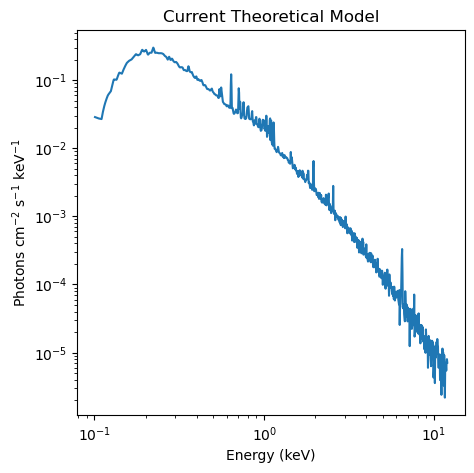

In [400]:
x.Plot("model")
xVals_no_bkg = x.Plot.x()[1:]
modVals_no_bkg = x.Plot.model()[1:]

plt.figure(figsize=(5, 5))

plt.plot(xVals_no_bkg, modVals_no_bkg)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(x.Plot.labels()[0])
plt.ylabel(x.Plot.labels()[1])
plt.title(x.Plot.labels()[2])

plt.show()

### Creating atable model ([XSPEC Table Model Generator](https://github.com/mbursa/xspec-table-models/tree/main)):

In [401]:
from xspec_table_models import XspecTableModelAdditive

In [403]:
parameter = ('Number', [current_cluster_num], False, False)
fits11 = XspecTableModelAdditive('model_atable_'+str(current_cluster_num)+'.fits', 
                                 'myAtableModel', dummyrsp[1:], [parameter])

In [404]:
# Energy spectrum (specific flux) in [erg/s/cm2/keV] given at each point of the energy grid.
atablemodel_input = [a*(1.6*10**(-9))/b/10000/1000*c for a, b, c in zip(photons, np.diff(dummyrsp), dummyrsp[1:])]
fits11.write(0, atablemodel_input, False)
fits11.save()

In [405]:
x.Model("atable{model_atable_19787.fits}")
#x.Xset.restore('t.xcm')

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.


*** Warning: default value of delta for parameter: Number must be non-zero, reset to 0.001 (frozen) 



Parameters have been automatically renormalized.

Model atable{model_atable_19787.fits}<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   myAtableModelNumber              1.97870E+04  frozen
   2    1   myAtableModelnorm                1.00000      +/-  0.0          
________________________________________________________________________



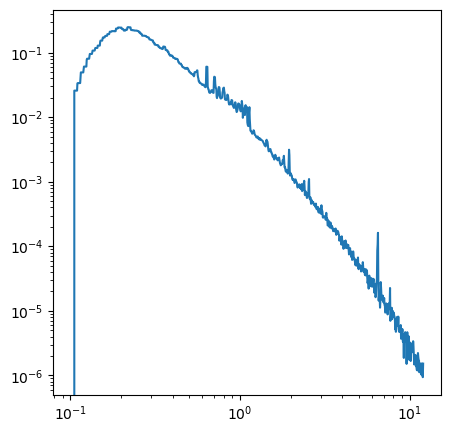

In [406]:
x.Plot.device = '/null'
x.Plot.xAxis = "keV"
x.Plot('model')

plt.figure(figsize=(5, 5))

xVals_atable = x.Plot.x()[1:]
modVals_atable = x.Plot.model()[1:]

plt.plot(xVals_atable, modVals_atable)
plt.xscale("log")
plt.yscale("log")

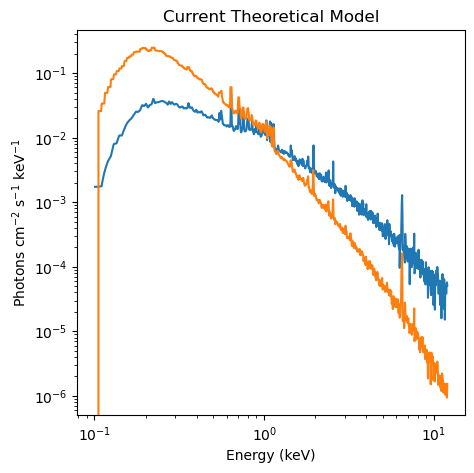

In [407]:
plt.figure(figsize=(5, 5))

plt.plot(xVals_no_bkg, [ui*iu*0.6 for ui, iu in zip(xVals_no_bkg, modVals_no_bkg)])

plt.plot(xVals_atable, modVals_atable)

plt.xscale('log')
plt.yscale('log')

plt.xlabel(x.Plot.labels()[0])
plt.ylabel(x.Plot.labels()[1])
plt.title(x.Plot.labels()[2])

plt.show()

### Adding background:

This empiric model for background is normalized for 1 min$^2$ = $(1/60)^2$ deg$^2$ = $2.778 \cdot 10^{-4}$ deg$^2$.

In [153]:
min2_to_deg2 = 1/60**2

In [154]:
df4 = pd.read_csv("utils/sky_bkg_full_arcmin_05cxb.xcm", header=None)[0]
bkg_model_name = df4[0][6:]

params={}

for i in range(1,18):
    params[i+3] = df4[i]
    
#params

In [155]:
print(R_500_rescaled) # degrees

print(np.pi*R_500_rescaled**2) #degrees^2

print(np.pi*R_500_rescaled**2*3600) #min^2

0.19248360419179314
0.1163958126681319
419.02492560527486


In [156]:
x.AllModels.clear()

x.Xset.chatter = 0

myModel_with_bkg = x.Model("myModel+const*"+bkg_model_name, setPars=params, sourceNum=1)
myModel_with_bkg(2).values = 1           # norm for myModel
myModel_with_bkg(2).frozen = True
myModel_with_bkg(3).values = np.pi*R_500_rescaled**2/min2_to_deg2 # area of cluster = factor before background

x.Xset.chatter = 10

x.AllModels.show()

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.

Parameters defined:
Model myModel<1> + constant<2>*constant<3>(apec<4> + wabs<5>(apec<6> + apec<7> + constant<8>*powerlaw<9>)) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   myModel    par1       Number   1.97870E+04  +/-  0.0          
   2    1   myModel    norm                1.00000      frozen
   3    2   constant   factor              419.025      +/-  0.0          
   4    3   constant   factor              9.76562E-04  +/-  0.0          
   5    4   apec       kT         keV      9.90000E-02  +/-  0.0          
   6    4   apec       Abundanc            1.00000      frozen
   7    4   apec       Redshift            0.0          frozen
   8    4   apec       norm                1.74000E-03  +/-  0.0          
   9    5   wabs       nH         10^22    1.80000E-02  +/-  0.0          
  10    6   apec       kT         keV      0.2

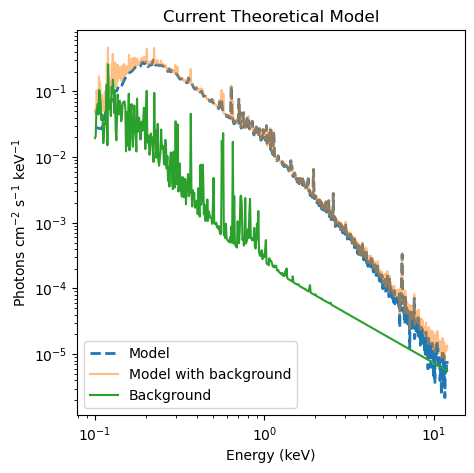

In [157]:
x.Plot("model")
xVals_with_bkg = x.Plot.x()[1:]
modVals_with_bkg = x.Plot.model()[1:]

plt.figure(figsize=(5, 5))

plt.plot(xVals_no_bkg, modVals_no_bkg, label="Model", linestyle = '--', linewidth=2)

plt.plot(xVals_with_bkg, modVals_with_bkg, label="Model with background", alpha=0.5)

plt.plot(xVals_bkg, [a*myModel_with_bkg(3).values[0] for a in modVals_bkg], label="Background")

plt.xscale('log')
plt.yscale('log')

plt.xlabel(x.Plot.labels()[0])
plt.ylabel(x.Plot.labels()[1])
plt.title(x.Plot.labels()[2])

plt.legend(loc=3)

plt.show()

### Fakeit

In [307]:
x.AllData.clear()

fs = x.FakeitSettings(response = '../erosita/erosita_pirmf_v20210719.rmf', 
                           arf = '../erosita/tm1_arf_open_000101v02.fits', 
                    background = '', 
                      exposure = 10000, 
                    correction = '', 
                  backExposure = '', 
                      fileName = 'fakeit.pha')
x.AllData.fakeit(nSpectra = 1, 
                 settings = fs, 
               applyStats = True,
               filePrefix = "",
                  noWrite = True)

xsFakeit cmd string:
fakeit nowrite 1 & ../erosita/erosita_pirmf_v20210719.rmf & ../erosita/tm1_arf_open_000101v02.fits & y & / & fakeit.pha & 10000, ,  


No background will be applied to fake spectrum #1

1 spectrum  in use
 

Fit statistic  : Chi-Squared                  938.21     using 1024 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                  938.21     using 1024 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 9.71e-01 with 1022 degrees of freedom
 Current data and model not fit yet.


In [308]:
x.AllData.show()


1 file 1 spectrum 
Spectrum 1  Spectral Data File: fakeit.pha
Net count rate (cts/s) for Spectrum:1  7.608e+05 +/- 8.722e+00
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-1024
  Telescope: eROSITA Instrument: TM1  Channel Type: PI
  Exposure Time: 1e+04 sec
 Using fit statistic: chi
 Using Response (RMF) File            ../erosita/erosita_pirmf_v20210719.rmf for Source 1
 Using Auxiliary Response (ARF) File  ../erosita/tm1_arf_open_000101v02.fits



***Warning: Fit is not current.


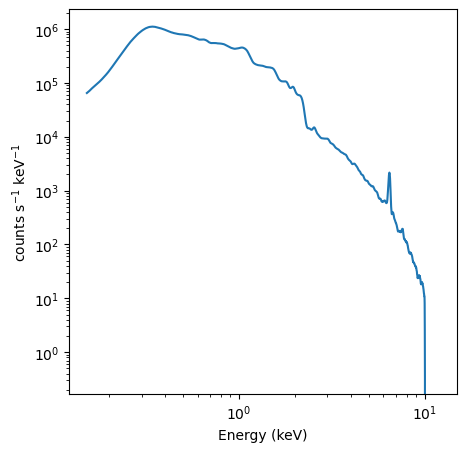

In [309]:
x.Plot("ldata")

xVals = x.Plot.x()[10:]
yVals = x.Plot.y()[10:]

plt.figure(figsize=(5, 5))

plt.plot(xVals, yVals)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(x.Plot.labels()[0])
plt.ylabel(x.Plot.labels()[1])
#plt.title(x.Plot.labels()[2])

#plt.ylim(10**(-1), 10**2)

plt.show()

#### Obsolete section: generating my own PHA files

XSPEC's “native” data format is the OGIP standard. See [XSPEC Data Formats](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node14.html). Useful tool: [ascii2pha](https://heasarc.gsfc.nasa.gov/docs/software/ftools/fhelp/ascii2pha.html) or [ftascii2pha](https://heasarc.gsfc.nasa.gov/lheasoft/help/ftascii2pha.html).

Also see here: [Appendix E: Associated Programs](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node322.html#AppendixPrograms). [SOXS](https://hea-www.cfa.harvard.edu/soxs/index.html) might be useful. And [HEASoftPY](https://heasarc.gsfc.nasa.gov/docs/software/heasoft/heasoftpy/). Maybe [profit](https://heasarc.gsfc.nasa.gov/docs/software/profit/manual/node16.html)?

Headers for table: [keywords](https://heasarc.gsfc.nasa.gov/docs/heasarc/caldb/docs/memos/cal_gen_92_002/cal_gen_92_002.html). Originally [here](https://heasarc.gsfc.nasa.gov/docs/heasarc/ofwg/docs/spectra/ogip_92_007/node6.html).

In [310]:
#x.AllData.notice("all")
x.AllData.ignore("**-0.4 7.0-**")
#x.AllData.ignore("bad")

    57 channels (1-57) ignored in spectrum #     1
   302 channels (723-1024) ignored in spectrum #     1

Fit statistic  : Chi-Squared                  685.73     using 665 bins.

Test statistic : Chi-Squared                  685.73     using 665 bins.
 Null hypothesis probability of 2.63e-01 with 663 degrees of freedom
 Current data and model not fit yet.



***Warning: Fit is not current.


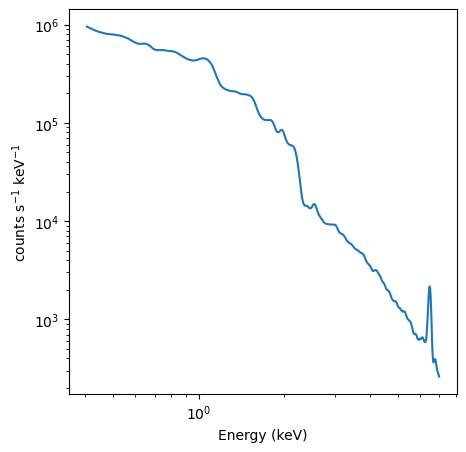

In [311]:
x.Plot("ldata")

xVals = x.Plot.x()
yVals = x.Plot.y()

plt.figure(figsize=(5, 5))

plt.plot(xVals, yVals)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(x.Plot.labels()[0])
plt.ylabel(x.Plot.labels()[1])
#plt.title(x.Plot.labels()[2])

plt.show()

#### Without background:

In [312]:
x.AllModels.clear()

mod = x.Model('phabs*apec')

zzzzz = current_cluster["z_true"]

mod(4).values = f"{zzzzz}"
mod(1).values = 0.01
mod(1).frozen = True
mod(3).frozen = False
#mod(3).values = 0.3

mod.show()


Fit statistic  : Chi-Squared              3.073486e+09     using 665 bins.

Test statistic : Chi-Squared              3.073486e+09     using 665 bins.
 Null hypothesis probability of 0.000000e+00 with 662 degrees of freedom
 Current data and model not fit yet.

Parameters have been automatically renormalized.

Model phabs<1>*apec<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   apec       kT         keV      1.00000      +/-  0.0          
   3    2   apec       Abundanc            1.00000      frozen
   4    2   apec       Redshift            0.0          frozen
   5    2   apec       norm                5512.58      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              3.049369e+09     using 665 bins.

Test statistic : Chi-Squared              3.049369e+09     using 665 bins.
 

#### With background:

In [313]:
list(params.values())

['0.000976562',
 '9.90000E-02   ',
 '1.00000     ',
 '0.0         ',
 '1.74000E-03   ',
 '1.80000E-02   ',
 '0.225000      ',
 '1.00000     ',
 '0.0         ',
 '7.47500E-04 ',
 '0.700000      ',
 '1.00000     ',
 '0.0         ',
 '8.9700E-05',
 '0.5',
 '1.47',
 '0.001052']

In [314]:
x.AllModels.clear()

x.Xset.chatter = 0

mod = x.Model('phabs*apec+const*'+bkg_model_name)

zzzzz = current_cluster["z_true"]

mod(1).values = 0.01
mod(1).frozen = True
mod(3).frozen = True
mod(3).values = 0.3
mod(4).values = f"{zzzzz}"

mod(6).values = np.pi*R_500_rescaled**2/min2_to_deg2 # area of cluster = factor before background

for i in range(7, 24):
    mod(i).frozen = True

for i in range(len(params)):
    mod(i+7).values = list(params.values())[i]
        
x.Xset.chatter = 10

mod.show()


Model phabs<1>*apec<2> + constant<3>*constant<4>(apec<5> + wabs<6>(apec<7> + apec<8> + constant<9>*powerlaw<10>)) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000E-02  frozen
   2    2   apec       kT         keV      1.00000      +/-  0.0          
   3    2   apec       Abundanc            0.300000     frozen
   4    2   apec       Redshift            3.47174E-02  frozen
   5    2   apec       norm                2032.73      +/-  0.0          
   6    3   constant   factor              419.025      +/-  0.0          
   7    4   constant   factor              9.76562E-04  frozen
   8    5   apec       kT         keV      9.90000E-02  frozen
   9    5   apec       Abundanc            1.00000      frozen
  10    5   apec       Redshift            0.0          frozen
  11    5   apec       norm                1.74000E-03  frozen
  12    6   wabs       nH         10^22    1.80000E-02  frozen
  13   

In [315]:
x.Fit.renorm('auto')
x.Fit.nIterations = 100
#x.Fit.query = 'yes'
#x.Fit.weight = 'standard'
x.Fit.statMethod = 'chi'

x.Fit.perform()

 Renormalization will be performed automatically
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

Fit statistic  : Chi-Squared              1.948820e+09     using 665 bins.

Test statistic : Chi-Squared              1.948820e+09     using 665 bins.
 Null hypothesis probability of 0.000000e+00 with 662 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl          2:kT        5:norm      6:factor
5.7692e+08   4.11432e+08  -3       1.11867       1249.57   4.91742e+08
3.26017e+08  2.047e+08    -4       1.40520       1822.09   4.27577e+08
1.14567e+08  4.96405e+07  -5       1.83273       3139.37   2.66364e+08
8.54889e+07  2.25554e+07  -6       2.15698       3568.31   2.04300e+08
8.4639e+07   3.60174e+06  -7       2.22545       3541.16   2.05888e+08
8.46364e+07  103825       -8       2.22742       3536.97   2.06290e+08
8.46364e+07  86.2729      -9       2.2274

In [316]:
#x.Xset.parallel.error = 4
#x.Xset.parallel.steppar = 4
#x.Xset.parallel.show()

In [317]:
#x.Fit.steppar('2 0.1 5 20 3 0.0 1 20')
#x.Plot("contour")

In [318]:
#x.AllModels.calcFlux('0.1 12.0')
#x.AllData(1).flux[0]

x.Fit.error('2')

Cannot do error calc: Reduced Chi^2 (= 127850) > maximum (2)


Exception: Error executing command: error

In [198]:
print(mod(2).values)
print(mod(2).error)

[2.342829482739557, 0.023428294827395568, 0.008, 0.008, 64.0, 64.0]
(2.2740927565271716, 2.412188119933535, 'FFFFFFFFF')


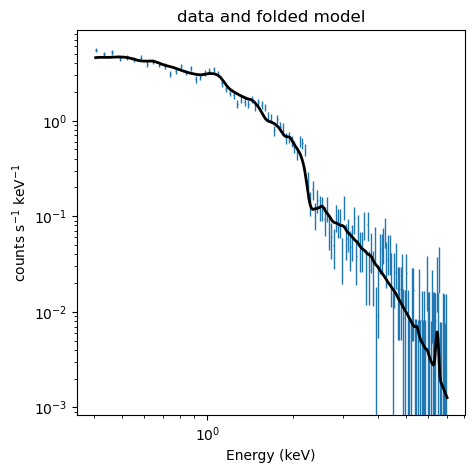

In [199]:
x.Plot("ldata")

xVals = x.Plot.x()
xErrors = x.Plot.xErr()
yVals = x.Plot.y()
yErrors = x.Plot.yErr()
modVals = x.Plot.model()

plt.figure(figsize=(5, 5))

plt.errorbar(xVals[::5], yVals[::5], yerr=yErrors[::5], xerr=xErrors[::5], fmt='', linewidth=0, elinewidth=1)
#plt.scatter(xVals, yVals)
plt.plot(xVals, modVals, linewidth=2, color='black')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(x.Plot.labels()[0])
plt.ylabel(x.Plot.labels()[1])
plt.title(x.Plot.labels()[2])

plt.show()

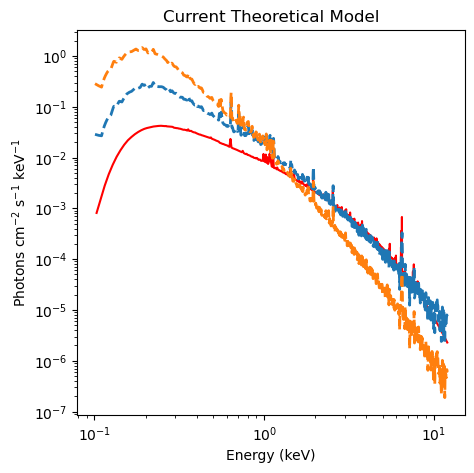

In [205]:
x.Plot('model')
xVals = x.Plot.x()
modVals = x.Plot.model()

plt.figure(figsize=(5, 5))

plt.plot(xVals, modVals, label="Best-fit model", color='red')

plt.plot(xVals_no_bkg, modVals_no_bkg, label="Model", linestyle = '--', linewidth=2)

plt.xscale('log')
plt.yscale('log')

plt.xlabel(x.Plot.labels()[0])
plt.ylabel(x.Plot.labels()[1])
plt.title(x.Plot.labels()[2])

plt.show()

In [178]:
x.AllModels.show()


Parameters defined:
Model phabs<1>*apec<2> + constant<3>*constant<4>(apec<5> + wabs<6>(apec<7> + apec<8> + constant<9>*powerlaw<10>)) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000E-02  frozen
   2    2   apec       kT         keV      2.78065      +/-  5.39906E-02  
   3    2   apec       Abundanc            0.300000     frozen
   4    2   apec       Redshift            3.47174E-02  frozen
   5    2   apec       norm                2.98577E-02  +/-  3.02972E-04  
   6    3   constant   factor              919.221      +/-  49.2806      
   7    4   constant   factor              9.76562E-04  frozen
   8    5   apec       kT         keV      9.90000E-02  frozen
   9    5   apec       Abundanc            1.00000      frozen
  10    5   apec       Redshift            0.0          frozen
  11    5   apec       norm                1.74000E-03  frozen
  12    6   wabs       nH         10^22    1.80000

### Average energy:

In [172]:
cr = x.AllData(1).rate[2] # total rate (without background)

s_i = x.AllData(1).values

cr, sum(s_i)                  # the same!

(4.453700000000008, 4.453700000000008)

In [173]:
ens = x.AllData(1).energies

In [174]:
E_i = np.zeros(len(ens))
dE = np.zeros(len(ens))

for i in ens:

    dE[ens.index(i)] = i[1]-i[0]
    E_i[ens.index(i)] = (i[0]+i[1])/2

In [175]:
E_i = [(i[0]+i[1])/2 for i in ens]

In [176]:
np.dot(E_i, s_i)/cr

1.0907824397944266

### Model for background:

This empiric model for background is normalized for 1 min$^2$ = $(1/60)^2$ deg$^2$ = $2.778 \cdot 10^{-4}$ deg$^2$.

In [2]:
model_bkg = x.Model("constant(apec + wabs*(apec + apec + const*pow))")

Reading APEC data from 3.0.9


**************************************************************
The wabs model is obsolete and is only included for comparison
with historical results. The tbabs model should be used for
the ISM or phabs for general photoelectric absorption.
**************************************************************

Model constant<1>(apec<2> + wabs<3>(apec<4> + apec<5> + constant<6>*powerlaw<7>)) Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   constant   factor              1.00000      +/-  0.0          
   2    2   apec       kT         keV      1.00000      +/-  0.0          
   3    2   apec       Abundanc            1.00000      frozen
   4    2   apec       Redshift            0.0          frozen
   5    2   apec       norm                1.00000      +/-  0.0          
   6    3   wabs       nH         10^22    1.00000      +/-  0.0          
   7    4   apec       kT         keV      1.00000      +/-  0.0     

In [3]:
#model_bkg.componentNames
params = [0.000976562, 
          9.90000E-02, 
          1.00000, 
          0.0, 
          1.74000E-03, 
          1.80000E-02, 
          0.225000, 
          1.00000, 
          0.0, 
          7.47500E-04, 
          0.700000, 
          1.00000, 
          0.0, 
          8.9700E-05, 
          0.5, 
          1.47, 
          0.001052]

In [4]:
x.Xset.chatter = 10

for i in range(len(params)):
    model_bkg(i+1).values = params[i]

In [5]:
x.AllModels.show()


Parameters defined:
Model constant<1>(apec<2> + wabs<3>(apec<4> + apec<5> + constant<6>*powerlaw<7>)) Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   constant   factor              9.76562E-04  +/-  0.0          
   2    2   apec       kT         keV      9.90000E-02  +/-  0.0          
   3    2   apec       Abundanc            1.00000      frozen
   4    2   apec       Redshift            0.0          frozen
   5    2   apec       norm                1.74000E-03  +/-  0.0          
   6    3   wabs       nH         10^22    1.80000E-02  +/-  0.0          
   7    4   apec       kT         keV      0.225000     +/-  0.0          
   8    4   apec       Abundanc            1.00000      frozen
   9    4   apec       Redshift            0.0          frozen
  10    4   apec       norm                7.47500E-04  +/-  0.0          
  11    5   apec       kT         keV      0.700000     +/-  0.0          
  12    5   apec       Abundanc  

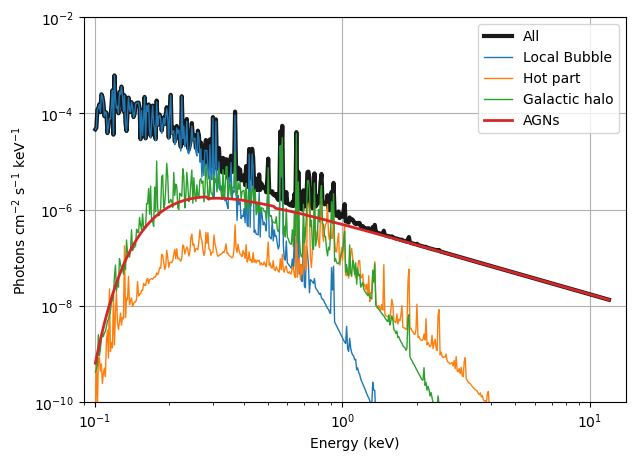

In [6]:
plt.figure(figsize=(7,5))

x.Plot.device = "/null"
x.AllData.dummyrsp(lowE=0.1, highE=12.0, nBins=512)

x.Plot("model")
x.Plot.xAxis = "keV"
x.Plot.add = True
xVals_bkg = x.Plot.x()
#yVals = x.Plot.y()
modVals_bkg = x.Plot.model()

y1 = x.Plot.addComp(1)
y2 = x.Plot.addComp(2)
y3 = x.Plot.addComp(3)
y4 = x.Plot.addComp(4)

plt.xlabel(x.Plot.labels()[0])
plt.ylabel(x.Plot.labels()[1])
#plt.title(x.Plot.labels()[2])

plt.plot(xVals_bkg, modVals_bkg, linestyle='-', linewidth=3, label='All', color='black', alpha=0.9)

plt.plot(xVals_bkg, y1, linestyle='-', linewidth=1, label='Local Bubble')#, color='blue')
plt.plot(xVals_bkg, y3, linestyle='-', linewidth=1, label='Hot part')
plt.plot(xVals_bkg, y2, linestyle='-', linewidth=1, label='Galactic halo')
plt.plot(xVals_bkg, y4, linestyle='-', linewidth=2, label='AGNs')

plt.xscale('log')
plt.yscale('log')
plt.xlim(0.09, 14.)
plt.ylim(10**(-10), 10**(-2))

plt.grid()
plt.legend()

plt.savefig('figures/background_model.pdf', format='pdf')
plt.show()

# All together: see other notebook